<a href="https://colab.research.google.com/github/Ayaz-75/Real-Time-Spatiotemporal-Scene-Intelligence/blob/master/Real_Time_Spatiotemporal_Scene_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics supervision lap filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.4/217.4 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 85.6 MB/s eta 0:00:00
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=0c2551409e6476df8646649b96c64af700875877d6f82819027f41da7de01f77
  Stored in directory: /root/.cache/pip/wheels/77/bf/4c/b0c3f4798a0166668752312a67118b27a3cd341e13ac0ae6ee
Successfully built filterpy


In [7]:
import cv2
import numpy as np
import time
from collections import defaultdict, deque
from ultralytics import YOLO
import supervision as sv
from google.colab.patches import cv2_imshow


# import cv2
# import numpy as np
# import time
# from collections import defaultdict, deque
# from ultralytics import YOLO
# import supervision as sv


In [3]:
detector = YOLO("yolov8n.pt")
tracker = sv.ByteTrack()

trajectory_history = defaultdict(lambda: deque(maxlen=30))
velocity_history = defaultdict(lambda: deque(maxlen=10))

# # Lightweight model for real-time
# detector = YOLO("yolov8n.pt")

# # ByteTrack tracker
# tracker = sv.ByteTrack()

# # Trajectory history per track
# trajectory_history = defaultdict(lambda: deque(maxlen=30))

# # Velocity history
# velocity_history = defaultdict(lambda: deque(maxlen=10))


In [8]:
def classify_activity(track_id):
    velocities = velocity_history[track_id]

    if len(velocities) < 5:
        return "Analyzing"

    avg_velocity = np.mean(velocities)

    if avg_velocity < 2:
        return "Standing"
    elif 2 <= avg_velocity < 8:
        return "Walking"
    else:
        return "Running"


In [9]:
def process_video(input_path, output_path="output.mp4"):

    cap = cv2.VideoCapture(input_path)

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps_input = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps_input, (width, height))

    total_frames = 0
    total_time = 0

    while cap.isOpened():

        start_time = time.time()

        ret, frame = cap.read()
        if not ret:
            break

        # -------------------------
        # Detection
        # -------------------------
        results = detector(frame)[0]
        detections = sv.Detections.from_ultralytics(results)

        person_mask = detections.class_id == 0
        detections = detections[person_mask]

        # -------------------------
        # Tracking
        # -------------------------
        tracked = tracker.update_with_detections(detections)

        for xyxy, track_id in zip(tracked.xyxy, tracked.tracker_id):

            x1, y1, x2, y2 = map(int, xyxy)
            center = ((x1 + x2)//2, (y1 + y2)//2)

            trajectory_history[track_id].append(center)

            if len(trajectory_history[track_id]) >= 2:
                prev = trajectory_history[track_id][-2]
                curr = trajectory_history[track_id][-1]
                velocity = np.linalg.norm(np.array(curr) - np.array(prev))
                velocity_history[track_id].append(velocity)

            activity = classify_activity(track_id)

            # Draw bounding box
            cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)

            cv2.putText(frame,
                        f"ID:{track_id} | {activity}",
                        (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (0,255,0),
                        2)

            # Draw trajectory
            for i in range(1, len(trajectory_history[track_id])):
                cv2.line(frame,
                         trajectory_history[track_id][i-1],
                         trajectory_history[track_id][i],
                         (255,0,0),
                         2)

        # FPS
        frame_time = time.time() - start_time
        fps = 1.0 / frame_time

        total_frames += 1
        total_time += frame_time

        cv2.putText(frame,
                    f"FPS: {fps:.2f}",
                    (20,30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0,0,255),
                    2)

        out.write(frame)

    cap.release()
    out.release()

    print("Average FPS:", total_frames / total_time)
    print("Saved to:", output_path)



# def process_video(video_path):
#     cap = cv2.VideoCapture(video_path)

#     total_frames = 0
#     total_time = 0

#     while cap.isOpened():
#         start_time = time.time()

#         ret, frame = cap.read()
#         if not ret:
#             break

#         # ---------------------------
#         # Stage 1: Detection
#         # ---------------------------
#         results = detector(frame)[0]
#         detections = sv.Detections.from_ultralytics(results)

#         # Keep only persons (COCO class 0)
#         person_mask = detections.class_id == 0
#         detections = detections[person_mask]

#         # ---------------------------
#         # Stage 2: Tracking
#         # ---------------------------
#         tracked = tracker.update_with_detections(detections)

#         for xyxy, track_id in zip(tracked.xyxy, tracked.tracker_id):

#             x1, y1, x2, y2 = map(int, xyxy)

#             center = ((x1 + x2)//2, (y1 + y2)//2)

#             # Save trajectory
#             trajectory_history[track_id].append(center)

#             # Compute velocity
#             if len(trajectory_history[track_id]) >= 2:
#                 prev = trajectory_history[track_id][-2]
#                 curr = trajectory_history[track_id][-1]
#                 velocity = np.linalg.norm(np.array(curr) - np.array(prev))
#                 velocity_history[track_id].append(velocity)

#             # Activity Classification
#             activity = classify_activity(track_id)

#             # ---------------------------
#             # Visualization
#             # ---------------------------

#             # Bounding box
#             cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)

#             # ID + Activity
#             cv2.putText(frame,
#                         f"ID:{track_id} | {activity}",
#                         (x1, y1-10),
#                         cv2.FONT_HERSHEY_SIMPLEX,
#                         0.6,
#                         (0,255,0),
#                         2)

#             # Trajectory line
#             for i in range(1, len(trajectory_history[track_id])):
#                 cv2.line(frame,
#                          trajectory_history[track_id][i-1],
#                          trajectory_history[track_id][i],
#                          (255,0,0),
#                          2)

#         # ---------------------------
#         # FPS Measurement
#         # ---------------------------
#         frame_time = time.time() - start_time
#         fps = 1.0 / frame_time

#         total_frames += 1
#         total_time += frame_time

#         cv2.putText(frame,
#                     f"FPS: {fps:.2f}",
#                     (20,30),
#                     cv2.FONT_HERSHEY_SIMPLEX,
#                     1,
#                     (0,0,255),
#                     2)

#         cv2.imshow("Spatiotemporal Intelligence System", frame)

#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

#     cap.release()
#     cv2.destroyAllWindows()

#     print("Average FPS:", total_frames / total_time)


In [10]:
process_video("/content/drive/MyDrive/input.mp4")



0: 384x640 13 persons, 9.0ms
Speed: 2.6ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 6.3ms
Speed: 2.5ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 6.1ms
Speed: 1.8ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 bicycle, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shap

In [12]:
from IPython.display import Video
Video("output.mp4")


In [15]:
from IPython.display import display
from PIL import Image

def process_video_smooth(video_path):

    cap = cv2.VideoCapture(video_path)

    # Create persistent display
    ret, frame = cap.read()
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    im = display(Image.fromarray(frame_rgb), display_id=True)

    while cap.isOpened():

        start_time = time.time()
        ret, frame = cap.read()
        if not ret:
            break

        # ---------------- Detection ----------------
        results = detector(frame)[0]
        detections = sv.Detections.from_ultralytics(results)

        person_mask = detections.class_id == 0
        detections = detections[person_mask]

        # ---------------- Tracking ----------------
        tracked = tracker.update_with_detections(detections)

        for xyxy, track_id in zip(tracked.xyxy, tracked.tracker_id):

            x1, y1, x2, y2 = map(int, xyxy)
            center = ((x1 + x2)//2, (y1 + y2)//2)

            trajectory_history[track_id].append(center)

            if len(trajectory_history[track_id]) >= 2:
                prev = trajectory_history[track_id][-2]
                curr = trajectory_history[track_id][-1]
                velocity = np.linalg.norm(np.array(curr) - np.array(prev))
                velocity_history[track_id].append(velocity)

            activity = classify_activity(track_id)

            # Draw box
            cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(frame,
                        f"ID:{track_id} | {activity}",
                        (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (0,255,0),
                        2)

            # Draw trajectory
            for i in range(1, len(trajectory_history[track_id])):
                cv2.line(frame,
                         trajectory_history[track_id][i-1],
                         trajectory_history[track_id][i],
                         (255,0,0),
                         2)

        # FPS
        fps = 1.0 / (time.time() - start_time)
        cv2.putText(frame,
                    f"FPS: {fps:.2f}",
                    (20,30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0,0,255),
                    2)

        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Update existing display (NO blinking)
        im.update(Image.fromarray(frame_rgb))

    cap.release()


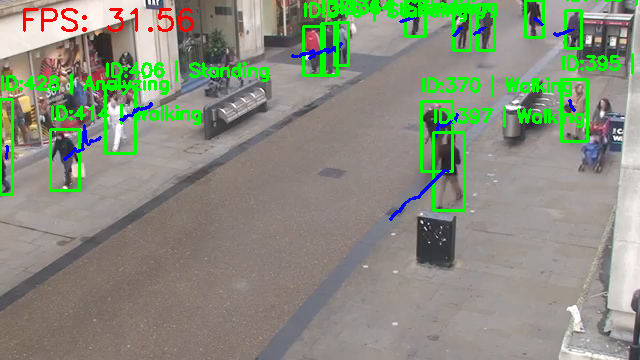


0: 384x640 13 persons, 16.2ms
Speed: 2.3ms preprocess, 16.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 9.5ms
Speed: 1.7ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 16.6ms
Speed: 1.5ms preprocess, 16.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 11.2ms
Speed: 2.5ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 9.0ms
Speed: 1.5ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 bicycle, 9.7ms
Speed: 1.7ms preprocess, 9.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 bicycle, 11.3ms
Speed: 2.0ms preprocess, 11.3ms inference, 2.0ms postproc

In [16]:
process_video_smooth("/content/drive/MyDrive/input.mp4")


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

In [18]:
def generate_synthetic_dataset(n_samples=1500):

    X = []
    y = []

    for _ in range(n_samples):

        activity = np.random.choice(["Standing","Walking","Running"])

        if activity == "Standing":
            velocity = np.random.normal(1, 0.5)
            acceleration = np.random.normal(0.1, 0.05)

        elif activity == "Walking":
            velocity = np.random.normal(5, 1.0)
            acceleration = np.random.normal(0.5, 0.2)

        else:
            velocity = np.random.normal(10, 2.0)
            acceleration = np.random.normal(1.5, 0.5)

        curvature = np.random.uniform(0,1)

        X.append([velocity, acceleration, curvature])
        y.append(["Standing","Walking","Running"].index(activity))

    return np.array(X), np.array(y)

X, y = generate_synthetic_dataset()


In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [20]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.long)


In [21]:
class ActivityClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )

    def forward(self, x):
        return self.net(x)

model = ActivityClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [22]:
epochs = 50
train_losses = []
val_losses = []

for epoch in range(epochs):

    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/50 | Train Loss: 1.0992 | Val Loss: 1.0906
Epoch 2/50 | Train Loss: 1.0903 | Val Loss: 1.0823
Epoch 3/50 | Train Loss: 1.0816 | Val Loss: 1.0739
Epoch 4/50 | Train Loss: 1.0730 | Val Loss: 1.0656
Epoch 5/50 | Train Loss: 1.0644 | Val Loss: 1.0573
Epoch 6/50 | Train Loss: 1.0559 | Val Loss: 1.0491
Epoch 7/50 | Train Loss: 1.0476 | Val Loss: 1.0411
Epoch 8/50 | Train Loss: 1.0395 | Val Loss: 1.0333
Epoch 9/50 | Train Loss: 1.0314 | Val Loss: 1.0255
Epoch 10/50 | Train Loss: 1.0234 | Val Loss: 1.0176
Epoch 11/50 | Train Loss: 1.0153 | Val Loss: 1.0098
Epoch 12/50 | Train Loss: 1.0073 | Val Loss: 1.0019
Epoch 13/50 | Train Loss: 0.9992 | Val Loss: 0.9939
Epoch 14/50 | Train Loss: 0.9911 | Val Loss: 0.9859
Epoch 15/50 | Train Loss: 0.9828 | Val Loss: 0.9777
Epoch 16/50 | Train Loss: 0.9744 | Val Loss: 0.9694
Epoch 17/50 | Train Loss: 0.9658 | Val Loss: 0.9610
Epoch 18/50 | Train Loss: 0.9571 | Val Loss: 0.9524
Epoch 19/50 | Train Loss: 0.9482 | Val Loss: 0.9435
Epoch 20/50 | Train L

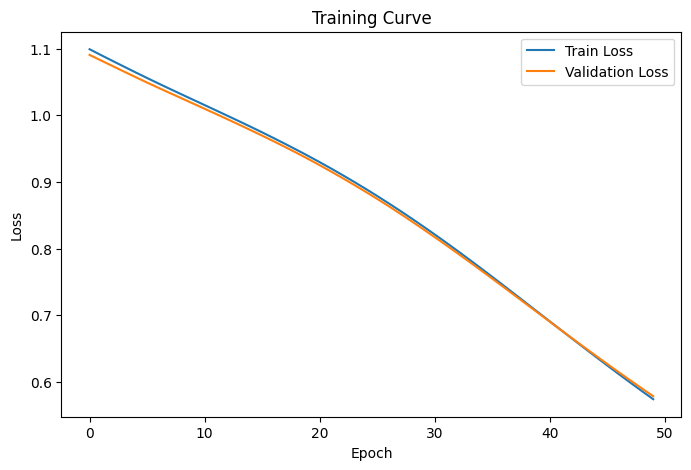

In [23]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Training Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [24]:
model.eval()
with torch.no_grad():
    logits = model(X_test)
    preds = torch.argmax(logits, dim=1).numpy()

accuracy = accuracy_score(y_test.numpy(), preds)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test.numpy(), preds,
                            target_names=["Standing","Walking","Running"]))


Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

    Standing       0.70      1.00      0.83       107
     Walking       1.00      0.50      0.66       101
     Running       0.94      1.00      0.97        92

    accuracy                           0.83       300
   macro avg       0.88      0.83      0.82       300
weighted avg       0.88      0.83      0.81       300



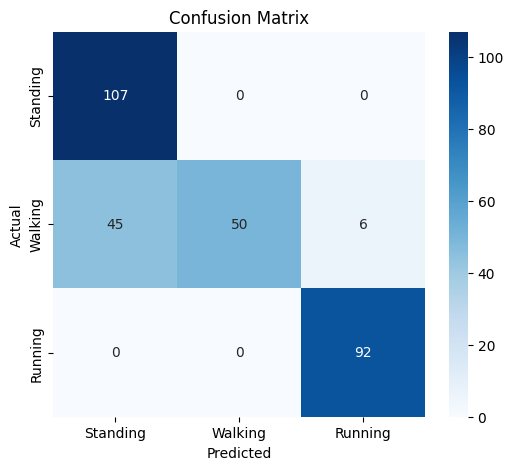

In [25]:
cm = confusion_matrix(y_test.numpy(), preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=["Standing","Walking","Running"],
            yticklabels=["Standing","Walking","Running"],
            cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [26]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(X_train.numpy(), y_train.numpy())

log_preds = log_model.predict(X_test.numpy())

print("MLP Accuracy:", accuracy)
print("Logistic Regression Accuracy:",
      accuracy_score(y_test.numpy(), log_preds))


MLP Accuracy: 0.83
Logistic Regression Accuracy: 0.99
